# Recommendation Systems Assignment

### MIE451/1513 UofT

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=fad973ecc3dc30e4110a3ae1f5cfc4745d8aec8445689d2c8fc7094f3fb4e306
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [4]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [5]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head() #100000x4

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [8]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating #userID, itemID start from 1
    ###########         end         ###########
    return matrix

In [9]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [10]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix): 
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]

                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()] #.nonzero() returns the indices, ratedItems contains only the nonzero values

                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [11]:
popularity_recsys = BaseLineRecSys('popularity')

In [12]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [13]:
x = popularity_recsys.getModel() #the matrix with filled in ratings

In [14]:
np.all(x<=1)

True

In [15]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:09, 1441.16it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [17]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [18]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [19]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [20]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:07, 1481.01it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [21]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine') #UxU if user, IxI if item
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='euclidean')) #UxU if user, IxI if item
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='manhattan')) #UxU if user, IxI if item

        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            #set every single non-zero ratings as 1, for normalization
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #for consideration of the NAN value thing
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #Cold start
            # if no one has rated this item before, use user average
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            # if no one has rated this item before, assign the entire item column with user avg rating
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            #set every single non-zero ratings as 1, for normalization
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix.T)
            # IxU: IxI mul IxU
            normalizer = np.matmul(ii_similarity, temp_matrix.T)
            #for consideration of the NAN value thing
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix.T)/normalizer
            #Cold start
            # if this user has rated nothing, use item average
            itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
            columns = np.sum(predictionMatrix, axis=0)
            # if this user has rated nothing, assign the entire user column with item avg rating
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.T
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [22]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [24]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Each metric has its own advantages. But usually we prefer cosine similarity. Since it captures the similarity of what kind of movies are liked by the user. For example, both users give good ratings on movie A but bad ratings on movie B, but their ratings are different. Using cosine similarity in this case will show that they are similar users but Euclidean and Manhatthan similarities will say that they are not that similar due to their different rating score.
Cosine similarity measures the variety preference difference between users. Euclidean and Manhattan distances measure the difference due to raring scores for some movies. For example, user A gives movie C and D 2 score and user B gives movie C and D 5 score, the Euclidean and Manhattan capture this difference.

### (b)

The Manhattan distance measrues the absolute differences of the Cartesian coordiantes. If there are outliers amoung users (like the User A and B from the above case). Manhattan metric gives lower similarity than Euclidean metric, demonstrates the user difference better.

## Q3

### (a)

In [25]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [26]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [27]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [28]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:21, 1232.51it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [58]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:13, 1369.83it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [30]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take) #return the indices for the top k largest values in prediction

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0] #return the indices for those 'like' in test

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take) #return the indices for the top k largest values in prediction

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0] #return the indices for those 'like' in test

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]  #return the indices for those 'like' in test

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take) #return the indices for the top k largest values in prediction where k = num of total 'like' is test
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name): #same as Preprocessor
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [35]:
# How to use CrossValidation Class?

In [59]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]

In [60]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [61]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3246.01it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3275.21it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3315.67it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3312.45it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3260.74it/s]


Processing algorithm user-cosine


20000it [00:06, 3249.99it/s]
20000it [00:06, 3307.07it/s]
20000it [00:06, 3286.08it/s]
20000it [00:06, 3276.18it/s]
20000it [00:06, 3239.82it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

User-cosine based collaborative filtering works slighter better than item-cosine based because the avergae number of ratings per user could be higher than the average number of ratings per item. meaning that the item cold-start problem is more susceptible.

## Q4

### (a)

In [39]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values #get the 10000x3 matrix,
        if self.test:
          train_vec, val_vec = train_test_split(train_vec) #default test set size
          pairs_val = val_vec.shape[0] #number of records in test set
          self.mean_rating_test = np.mean(val_vec[:, 2])  #avg rating for test set
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating for train set
        pairs_train = train_vec.shape[0]  # num of records in tain set
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = sqrt(0.1) * np.random.randn(num_item, self.num_feat)  # item M x D(latent feature) 
        self.w_User = sqrt(0.1) * np.random.randn(num_user, self.num_feat)  # user N x D(latent feature) 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffle the above order every time

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1)) # get each batch
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis = 1) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis = 1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis = 1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [40]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

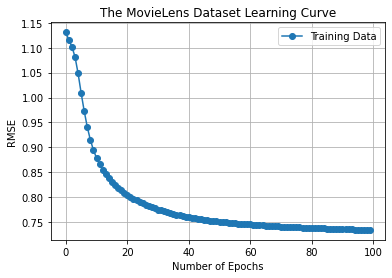

In [41]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

After I set the test_mode to 'True', I found that the best number of epoches is 20. When >20, the test RMSE starts increasing although the tain RMSE still decreases, meaning there is an overfitting problem.

## Q5

### (a)

In [42]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       pmf]
metrics = ['RMSE','P@K','RPrecision']
performance = {}
for metric in metrics:
    print('Metric:', metric)
    cv = CrossValidation(metric)
    results = cv.run(algorithm_instances, num_users, num_items, k=5)
    performance[metric] = results

Metric: RMSE
Processing algorithm popularity


20000it [00:06, 3276.19it/s]
20000it [00:06, 3304.15it/s]
20000it [00:06, 3298.54it/s]
20000it [00:06, 3258.43it/s]
20000it [00:06, 3267.84it/s]


Processing algorithm useraverage


20000it [00:06, 3256.80it/s]
20000it [00:06, 3317.56it/s]
20000it [00:05, 3339.45it/s]
20000it [00:06, 3250.57it/s]
20000it [00:06, 3301.92it/s]


Processing algorithm user-cosine


20000it [00:06, 3274.69it/s]
20000it [00:06, 3300.30it/s]
20000it [00:06, 3324.53it/s]
20000it [00:06, 3301.11it/s]
20000it [00:06, 3299.02it/s]


Processing algorithm PMF


20000it [00:11, 1796.54it/s]
20000it [00:11, 1758.47it/s]
20000it [00:11, 1801.19it/s]
20000it [00:11, 1782.34it/s]
20000it [00:11, 1778.04it/s]


Metric: P@K
Processing algorithm popularity


20000it [00:06, 3267.04it/s]
20000it [00:06, 3285.03it/s]
20000it [00:06, 3279.83it/s]
20000it [00:06, 3299.92it/s]
20000it [00:06, 3313.59it/s]


Processing algorithm useraverage


20000it [00:06, 3275.54it/s]
20000it [00:06, 3232.52it/s]
20000it [00:06, 3226.39it/s]
20000it [00:06, 3239.08it/s]
20000it [00:06, 3252.77it/s]


Processing algorithm user-cosine


20000it [00:06, 3301.95it/s]
20000it [00:06, 3261.92it/s]
20000it [00:06, 3244.96it/s]
20000it [00:06, 3229.63it/s]
20000it [00:06, 3251.03it/s]


Processing algorithm PMF


20000it [00:10, 1845.83it/s]
20000it [00:11, 1750.55it/s]
20000it [00:11, 1747.11it/s]
20000it [00:11, 1779.59it/s]
20000it [00:11, 1792.64it/s]


Metric: RPrecision
Processing algorithm popularity


20000it [00:06, 3240.38it/s]
20000it [00:06, 3194.80it/s]
20000it [00:06, 3250.06it/s]
20000it [00:06, 3242.62it/s]
20000it [00:06, 3295.21it/s]


Processing algorithm useraverage


20000it [00:06, 3250.69it/s]
20000it [00:06, 3216.49it/s]
20000it [00:06, 3236.33it/s]
20000it [00:06, 3191.74it/s]
20000it [00:06, 3213.31it/s]


Processing algorithm user-cosine


20000it [00:06, 3315.20it/s]
20000it [00:06, 3233.17it/s]
20000it [00:06, 3188.67it/s]
20000it [00:06, 3242.35it/s]
20000it [00:06, 3245.61it/s]


Processing algorithm PMF


20000it [00:11, 1765.83it/s]
20000it [00:11, 1737.34it/s]
20000it [00:11, 1756.66it/s]
20000it [00:11, 1754.11it/s]
20000it [00:11, 1790.47it/s]


In [43]:
for metric in performance:
    print('---------------------{}--------------------'.format(metric))
    print('{:>12}{:>12}{:>12}{:>12}'.format('Algorithm','Mean','CI_lower','CI_upper'))
    for algorithm in performance[metric]:
        print('{:>12}{:>12}{:>12}{:>12}'.format(algorithm,round(performance[metric][algorithm][1], 3),round(performance[metric][algorithm][2], 3),round(performance[metric][algorithm][3], 3)))

---------------------RMSE--------------------
   Algorithm        Mean    CI_lower    CI_upper
  popularity       3.159       3.139       3.179
 useraverage       1.044       1.029       1.059
 user-cosine       1.017       1.009       1.026
         PMF       0.971       0.957       0.985
---------------------P@K--------------------
   Algorithm        Mean    CI_lower    CI_upper
  popularity       0.551       0.405       0.696
 useraverage       0.474       0.342       0.605
 user-cosine       0.556        0.41       0.702
         PMF       0.547       0.404       0.691
---------------------RPrecision--------------------
   Algorithm        Mean    CI_lower    CI_upper
  popularity       0.718       0.707       0.729
 useraverage       0.646        0.64       0.652
 user-cosine       0.721        0.71       0.732
         PMF       0.714       0.703       0.726


### (b)

*   Useraverage based cannot be evaluated with P@K and RPrecision. Since for all the unrated movies, we set the ratings as user average rating, meaning that all the unrated movies will have the same rating for a user. When we calculate P@K and RPrecision, this may have effects on the ranking of the rating scores for each user. 
*   Popularity based cannot be evaluated by RMSE since the popularity is measured by # of user liked / # of user rated which means the popularity is between [0,1] while the true rating should be between 1-5. This will give very big RMSE.

### (c)

*  For RMSE, PMF works best since PMF is an optimizaiton problem that we exploit the latent varibles and optimize the decompossed matices to minimize the error between the prediciton and the real rating.

*  For P@K, user-cosine works best since user-cosine utilizes the similarity between users and since the ratings are predicted based on other similar users, if other similar users like the movie, the target user may like the movie as well and the prediction rating will be higher. Therefore, the top recommended movies will be more accurate since they are predicted based on other similar users' preference.
*  For RPrecision, user-cosine works best and the reason is the same as P@K.

### (d)

*  Perfect RMSE implies perfect ranking, but good RMSE is not required for good ranking. A perfect RMSE indicates well generation of the learned model which gives better rankings. But a decent/good RMSE does not have perfect generation which means those high ratings samples may not be generated well(the low rating samples may be generated well which could also lead to a decent RMSE).
*  A good ranking metrics does not imply good RMSE since the ranking metrics focus on the top k items. If the other items  perform bad but it can still give good performance using ranking metrics while the RMSE will be bad.

## Q6

### (a)

In [44]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [45]:
User_Item_Matix = dataPreprocessor(rating_df, num_users, num_items)
vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
itemPopularity = np.zeros((num_items))
for item in range(num_items):
    numOfUsersRated = len(User_Item_Matix[:, item].nonzero()[0])
    numOfUsersLiked = len(vf(User_Item_Matix[:, item]).nonzero()[0])
    if numOfUsersRated == 0:
        itemPopularity[item] = 0
    else:
        itemPopularity[item] = numOfUsersLiked/numOfUsersRated

In [65]:
sorted_popularity = itemPopularity[np.argsort(itemPopularity)][490:493]
sorted_popularity

array([0.24489796, 0.24561404, 0.24626866])

In [66]:
Movie_Name = moviesDF['movieTitle'][np.argsort(itemPopularity)][490:493]
Movie_Name

823     Great White Hype, The (1996)
826                  Daylight (1996)
1046             Multiplicity (1996)
Name: movieTitle, dtype: object

In [48]:
Item_similarity_matrix = 1 - pairwise_distances(User_Item_Matix.T, metric='cosine')

In [49]:
similarity_df = pd.DataFrame(data=Item_similarity_matrix, columns=moviesDF.movieTitle,index=moviesDF.movieTitle.values)
similarity_df.head()

movieTitle,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),Seven (Se7en) (1995),"Usual Suspects, The (1995)",Mighty Aphrodite (1995),"Postino, Il (1994)",Mr. Holland's Opus (1995),French Twist (Gazon maudit) (1995),From Dusk Till Dawn (1996),"White Balloon, The (1995)",Antonia's Line (1995),Angels and Insects (1995),Muppet Treasure Island (1996),Braveheart (1995),Taxi Driver (1976),Rumble in the Bronx (1995),"Birdcage, The (1996)","Brothers McMullen, The (1995)",Bad Boys (1995),Apollo 13 (1995),Batman Forever (1995),Belle de jour (1967),Crimson Tide (1995),Crumb (1994),Desperado (1995),"Doom Generation, The (1995)",Free Willy 2: The Adventure Home (1995),Mad Love (1995),Nadja (1994),"Net, The (1995)",Strange Days (1995),"To Wong Foo, Thanks for Everything! Julie Newmar (1995)",...,Angel Baby (1995),Sudden Manhattan (1996),"Butcher Boy, The (1998)",Men With Guns (1997),Hana-bi (1997),"Niagara, Niagara (1997)","Big One, The (1997)","Butcher Boy, The (1998)","Spanish Prisoner, The (1997)",Temptress Moon (Feng Yue) (1996),Entertaining Angels: The Dorothy Day Story (1996),Chairman of the Board (1998),"Favor, The (1994)",Little City (1998),Target (1995),"Substance of Fire, The (1996)",Getting Away With Murder (1996),Small Faces (1995),"New Age, The (1994)",Rough Magic (1995),Nothing Personal (1995),8 Heads in a Duffel Bag (1997),"Brother's Kiss, A (1997)",Ripe (1996),"Next Step, The (1995)",Wedding Bell Blues (1996),MURDER and murder (1996),Tainted (1998),"Further Gesture, A (1996)",Kika (1993),Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
Toy Story (1995),1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,0.468291,0.460392,0.417509,0.347678,0.574377,0.224120,0.273916,0.046232,0.191772,0.232930,0.339196,0.527169,0.338105,0.467598,0.567950,0.227295,0.208472,0.592877,0.361657,0.150959,0.439441,0.259257,0.288536,0.090654,0.136757,0.108560,0.069805,0.368420,0.278386,0.246123,...,0.065390,0.010550,0.023592,0.014155,0.023592,0.023592,0.023592,0.023592,0.023592,0.014226,0.0,0.058979,0.047183,0.032856,0.035387,0.048189,0.058979,0.058979,0.035387,0.0,0.0,0.067404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033363,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
GoldenEye (1995),0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,0.468506,0.459946,0.213972,0.125463,0.253162,0.098185,0.390438,0.113063,0.030692,0.091550,0.319308,0.483349,0.278182,0.434907,0.306639,0.206481,0.408737,0.483077,0.581119,0.089355,0.462797,0.160738,0.479187,0.072342,0.087347,0.215247,0.184592,0.562970,0.334570,0.256668,...,0.049324,0.035017,0.078299,0.046980,0.078299,0.078299,0.078299,0.078299,0.078299,0.000000,0.0,0.000000,0.078299,0.000000,0.104399,0.000000,0.000000,0.000000,0.104399,0.0,0.0,0.074571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055366,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
Four Rooms (1995),0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,0.361165,0.319295,0.271402,0.190242,0.266335,0.167609,0.404239,0.126564,0.105377,0.187733,0.194546,0.293732,0.233814,0.381910,0.306447,0.214125,0.261303,0.269296,0.253074,0.126347,0.259129,0.185187,0.404930,0.179008,0.046315,0.073332,0.051270,0.240534,0.277311,0.176729,...,0.036615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009736,0.0,0.000000,0.096875,0.000000,0.000000,0.000000,0.064583,0.064583,0.096875,0.0,0.0,0.018452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
Get Shorty (1995),0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.4

In [67]:
print('----------------------------------------------------------')
for movie in Movie_Name:
    print('Top 5 most similar movies to {}'.format(movie))
    print('')
    print(moviesDF['movieTitle'][np.argsort(similarity_df[movie].tolist())[::-1]][1:6].to_string())
    print('----------------------------------------------------------')

----------------------------------------------------------
Top 5 most similar movies to Great White Hype, The (1996)

720                                       Mallrats (1995)
1058    Don't Be a Menace to South Central While Drink...
819                                      Space Jam (1996)
409                                        Kingpin (1996)
26                                        Bad Boys (1995)
----------------------------------------------------------
Top 5 most similar movies to Daylight (1996)

684          Executive Decision (1996)
596                      Eraser (1996)
404         Mission: Impossible (1996)
146    Long Kiss Goodnight, The (1996)
120      Independence Day (ID4) (1996)
----------------------------------------------------------
Top 5 most similar movies to Multiplicity (1996)

404       Mission: Impossible (1996)
120    Independence Day (ID4) (1996)
741                    Ransom (1996)
545              Broken Arrow (1996)
596                    Eraser (1996

### (b)

I choose Great White Hype, The (1996),Daylight (1996), Multiplicity (1996) which have the popularity score of around 0.24, meaning they are not so popular. Since we are using item-item cosine similarity just based on the ratings, which are rated by the users subjectively, the factors leading to the similarity may include movie type, director/actors/actress, production areas, movie description etc and the cosine similarity cannot capture these implicit factors. Also the not-so-popular movies may have a sparse item vector, which do not provide a lot of information

## Q7

### (a)

In [51]:
temp_matrix = np.zeros(User_Item_Matix.shape)
temp_matrix[User_Item_Matix.nonzero()] = 1
user_ratings = np.sum(temp_matrix, axis=1)

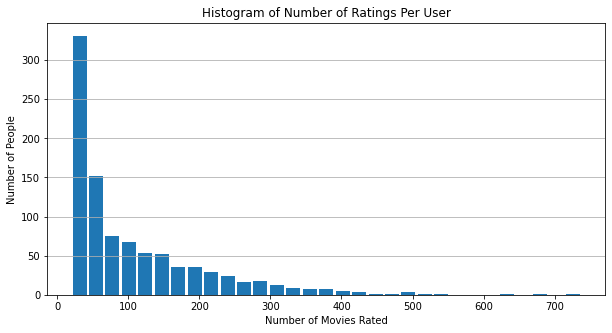

In [52]:
plt.figure(figsize=(10,5))
plt.hist(user_ratings, bins='auto', rwidth=0.85)
plt.ylabel('Number of People')
plt.xlabel('Number of Movies Rated')
plt.title('Histogram of Number of Ratings Per User')
plt.grid(axis='y')
plt.show()

In [53]:
#Choose tau = 200
More_rating_num = len(np.argwhere(user_ratings > 200))
Few_rating_num = len(np.argwhere(user_ratings <= 200))
More_rating_indices = np.argwhere(user_ratings > 200).reshape(More_rating_num)
Few_rating_indices = np.argwhere(user_ratings <= 200).reshape(Few_rating_num)

In [54]:
More_rating_df = rating_df[rating_df['userID'].isin(More_rating_indices)]
Few_rating_df = rating_df[rating_df['userID'].isin(Few_rating_indices)]

In [55]:
#More rating users (tau > 200)
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(More_rating_df, num_users, num_items)
UU_More = user_cosine_recsys.evaluate_test(More_rating_df, copy=True)

item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(More_rating_df, num_users, num_items)
II_More = item_cosine_recsys.evaluate_test(More_rating_df, copy=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
16734it [00:05, 3285.27it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
16734it [00:04, 3377.99it/s]


In [56]:
#Few rating users (tau <= 200)
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(Few_rating_df, num_users, num_items)
UU_Few = user_cosine_recsys.evaluate_test(Few_rating_df, copy=True)

item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(Few_rating_df, num_users, num_items)
II_Few = item_cosine_recsys.evaluate_test(Few_rating_df, copy=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
83098it [00:53, 1542.63it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
83098it [00:53, 1560.14it/s]


In [57]:
df_list = [UU_More, II_More, UU_Few, II_Few]
case = ['More-User&User:', 'More-Item&Item:', 'Few-User&User:', 'Few-Item&Item:']
print('----------RMSE----------')
for i, df in enumerate(df_list):
    RMSE = sqrt(mean_squared_error(df.iloc[:,2], df.iloc[:,4]))
    print(case[i], round(RMSE,6))

----------RMSE----------
More-User&User: 0.856974
More-Item&Item: 0.997502
Few-User&User: 0.946119
Few-Item&Item: 0.971777


*  I choose tau = 200 as a threshold.
*  For user-user collaborative filtering, 'above the threshold' case performs better with lower RMSE, since these users rated more movies which give less sparse vectors with more information to compute the user similarity.
*  For item-item collaborative filtering, 'below the threshold' case performs better with lower RMSE,
since there are more users in this group, giving higher probability of higher number of ratings for each item, which potentially provides more information to compute the item similarity.

## Q8

In [328]:
class CompetitionRecSys(object):
    """
    You can define new methods if you need. Don't use global variables in the class. 
    """
    def __init__(self, num_feat=70, epsilon=0.5, _lambda=0.3, momentum=0.99, maxepoch=20, num_batches=100, batch_size=1000):
        """
        Initialization of the class
        1. Make sure to fill out self.pred_column_name, the name you give  to your competition method
        
        """
        ########## your code goes here ###########
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name = 'PMF_adjusted'
        ###########         end         ###########

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return... 
        
        NOTES:
            This function is where you train your model
        """
                
        ########## your code goes here ###########
        train_vec = train_vec.iloc[:, :3].values #get the 10000x3 matrix,
        if self.test:
          train_vec, val_vec = train_test_split(train_vec) #default test set size
          pairs_val = val_vec.shape[0] #number of records in test set
          self.mean_rating_test = np.mean(val_vec[:, 2])  #avg rating for test set
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating for train set
        pairs_train = train_vec.shape[0]  # num of records in tain set
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = sqrt(0.1) * np.random.randn(num_item, self.num_feat)  # item M x D(latent feature) 
        self.w_User = sqrt(0.1) * np.random.randn(num_user, self.num_feat)  # user N x D(latent feature) 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffle the above order every time

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1)) # get each batch
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis = 1) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis = 1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis = 1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))
        ###########         end         ###########

        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction 
            Please fill out: prediction.loc[index, self.pred_column_name] = None                            
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            ########### your code goes here ###########
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
            ###########         end         ###########

        return prediction
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        ########### your code goes here ###########
        try:
            self.w_Item = None 
            self.w_User = None
        except:
            print("You do not have model..")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")
        ##########         end         ###########


In [329]:
competition = CompetitionRecSys()
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances, num_users, num_items)

Processing algorithm PMF_adjusted


20000it [00:13, 1510.00it/s]
20000it [00:12, 1543.31it/s]
20000it [00:12, 1571.79it/s]
20000it [00:12, 1569.21it/s]
20000it [00:12, 1562.28it/s]


In [330]:
rp

{'PMF_adjusted': [[0.7253015851772032,
   0.7163200018830184,
   0.7231795717386471,
   0.7331658523416033,
   0.7381972727603188],
  0.7272328567801581,
  0.7165757156284993,
  0.737889997931817]}

I just did hyperparameter tuning for the PMF model. I changed the momentum, epsilon, lambda and number of featues.
*  The momentum acts as a damping factor, which damps the oscillations.
*  Epsilon is the learning rate, changed it to 0.5 for slower convergence.
*  Lambda is regularization, increased it a bit to give more penalty.
*  Increased the number of featues to get better relationship for the latent variables and the prediction.

# Validation

In [68]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [69]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [70]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [71]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [72]:
validatePopularityRecSys()

### User Average Based Recommendation

In [73]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [74]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [75]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [76]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [77]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [78]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [79]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [80]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [81]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [82]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [83]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [84]:
validatePMFRecSys(validation_df=validation_df)